In [1]:
from nipype.interfaces import fsl
from nipype.interfaces import io as nio
from nipype.interfaces import utility as util
import nipype.pipeline.engine as pe

In [2]:
templates = {'slab2t1_weighted':'/home/gdholla1/data/daphne/registration/slab2t1_weighted/_subject_id_{subject_id}/run1_dtype_mcf_mask_gms_mean_flirt_whole_brain_epi_flirt.mat',
              'tsnr':'/home/gdholla1/data/daphne/preprocessed/tsnr_file/_subject_id_{subject_id}/_fwhm_0.0/_tsnr*/run*_dtype_mcf_mask_gms_tempfilt_maths_tsnr.nii.gz',
             'mean_epi':'/home/gdholla1/data/daphne/preprocessed/feat_preprocess/mean/_subject_id_{subject_id}/_fwhm_0.0/run1_dtype_mcf_mask_gms_mean.nii.gz',
             'tsnr_phys':'/home/gdholla1/data/daphne/preprocess_phys/tsnr_file/_subject_id_{subject_id}/_fwhm_0.0/_tsnr*/run*_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_maths_tsnr.nii.gz',
             'epi_filtered':'/home/gdholla1/data/daphne/preprocessed/motion_regressors_filtered_files/_subject_id_{subject_id}/_fwhm_0.0/_addmean*/run*_dtype_mcf_mask_gms_tempfilt_regfilt_maths.nii.gz',
             'epi_filtered_phys':'/home/gdholla1/data/daphne/preprocess_phys/motion_regressors_filtered_files/_subject_id_{subject_id}/_fwhm_0.0/_addmean*/run*_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths.nii.gz',
             'tse2t1_weighted_mat':'/home/gdholla1/data/daphne/registration_max/tse2t1_weighted/mats/{subject_id}.mat',
             'tse2t1_weighted_warp':'/home/gdholla1/data/daphne/registration_max/tse2t1_weighted/warps/{subject_id}.nii.gz',
             'tse':'/home/gdholla1/data/daphne/clean/{subject_id}/tse.nii.gz',
             't1_weighted':'/home/gdholla1/data/daphne/clean/{subject_id}/t1.nii.gz',}

mask_templates = {'conjunct_mask':'/home/gdholla1/data/daphne/masks/tse_space/{subject_id}/{mask}_conjunct.nii.gz',
                 'disjunct_mask':'/home/gdholla1/data/daphne/masks/tse_space/{subject_id}/{mask}_disjunct.nii.gz',}

In [19]:
def extract_weighted_timeseries(data_fn, mask_fn):
    import nibabel as nb
    import numpy as np
    from nipype.utils.filemanip import split_filename
    import os
    
    data_image = nb.load(data_fn)
    mask_image = nb.load(mask_fn)
    
    data = data_image.get_data()
    mask = mask_image.get_data()
 
    
    if len(data.shape) == len(mask.shape):
        ts = (data[mask > 0] * mask[mask > 0]  / mask.sum()).sum(0)        
        ts = np.array([ts])
    else:
        ts = (data[mask > 0] * mask[mask > 0][:, np.newaxis]  / mask.sum()).sum(0)
    
    _, fn, _ = split_filename(data_fn)
    new_fn = os.path.abspath('%s_weighted.txt' % fn)
    
    np.savetxt(new_fn, np.array(ts))
    
    return new_fn
    

In [20]:
extract_weighted_timeseries('/home/gdholla1/data/daphne/preprocessed/tsnr_file/_subject_id_S03/_fwhm_0.0/_tsnr0/run1_dtype_mcf_mask_gms_tempfilt_maths_tsnr.nii.gz',
                            '/home/gdholla1/data/daphne/registration_max/conjunct_masks/_subject_id_S03/_mask_LC_L/_interp_trilinear/LC_L_conjunct_warp.nii.gz')

'/home/gdholla1/notebooks/2016_daphne/run1_dtype_mcf_mask_gms_tempfilt_maths_tsnr_weighted.txt'

In [21]:
import glob
subject_ids = [fn.split('/')[-1][:] for fn in glob.glob('/home/gdholla1/data/daphne/clean/*')]

In [22]:
workflow = pe.Workflow(name='register_max_daphne', base_dir='/home/gdholla1/workflow_folders/')

identity = pe.Node(util.IdentityInterface(fields=['subject_id']), name='identity')
identity.iterables = [('subject_id', subject_ids)]

selector = pe.Node(nio.SelectFiles(templates), name='selector')
workflow.connect(identity, 'subject_id', selector, 'subject_id')

mask_selector = pe.Node(nio.SelectFiles(mask_templates), name='mask_selector')
workflow.connect(identity, 'subject_id', mask_selector, 'subject_id')
mask_selector.iterables = [('mask', ['LC_L', 'LC_R'])]

invert_warp = pe.Node(fsl.InvWarp(), name='invert_warp')
workflow.connect(selector, 'tse2t1_weighted_warp', invert_warp, 'warp')
workflow.connect(selector, 'tse', invert_warp, 'reference')

invert_mat = pe.Node(fsl.ConvertXFM(invert_xfm=True), name='invert_mat')
workflow.connect(selector, 'tse2t1_weighted_mat', invert_mat, 'in_file')

t1_weighted2tse = pe.Node(fsl.ApplyWarp(), name='t1_weighted2tse')
workflow.connect(selector, 't1_weighted', t1_weighted2tse, 'in_file')
workflow.connect(invert_mat, 'out_file', t1_weighted2tse, 'premat')
workflow.connect(invert_warp, 'inverse_warp', t1_weighted2tse, 'field_file')
workflow.connect(selector, 'tse', t1_weighted2tse, 'ref_file')

t1_weighted2slab = pe.Node(fsl.ConvertXFM(invert_xfm=True), name='t1_weighted2slab')
workflow.connect(selector, 'slab2t1_weighted', t1_weighted2slab, 'in_file')

tse2slab = pe.Node(fsl.ApplyWarp(), name='tse2slab')
workflow.connect(selector, 'tse', tse2slab, 'in_file')
workflow.connect(selector, 'tse2t1_weighted_mat', tse2slab, 'premat')
workflow.connect(selector, 'tse2t1_weighted_warp', tse2slab, 'field_file')
workflow.connect(t1_weighted2slab, 'out_file', tse2slab, 'postmat')
workflow.connect(selector, 'mean_epi', tse2slab, 'ref_file')


tse2slab_conjunct = pe.Node(fsl.ApplyWarp(), name='tse2slab_conjunct')
tse2slab_conjunct.iterables = [('interp', ['trilinear', 'nn'])]
workflow.connect(mask_selector, 'conjunct_mask', tse2slab_conjunct, 'in_file')
workflow.connect(selector, 'tse2t1_weighted_mat', tse2slab_conjunct, 'premat')
workflow.connect(selector, 'tse2t1_weighted_warp', tse2slab_conjunct, 'field_file')
workflow.connect(t1_weighted2slab, 'out_file', tse2slab_conjunct, 'postmat')
workflow.connect(selector, 'mean_epi', tse2slab_conjunct, 'ref_file')

tse2slab_disjunct = pe.Node(fsl.ApplyWarp(), name='tse2slab_disjunct')
tse2slab_disjunct.iterables = [('interp', ['trilinear', 'nn'])]
workflow.connect(mask_selector, 'disjunct_mask', tse2slab_disjunct, 'in_file')
workflow.connect(selector, 'tse2t1_weighted_mat', tse2slab_disjunct, 'premat')
workflow.connect(selector, 'tse2t1_weighted_warp', tse2slab_disjunct, 'field_file')
workflow.connect(t1_weighted2slab, 'out_file', tse2slab_disjunct, 'postmat')
workflow.connect(selector, 'mean_epi', tse2slab_disjunct, 'ref_file')

ds = pe.Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = '/home/gdholla1/data/daphne/registration_max/'

ds.inputs.substitutions = [('interp_nn', 'interp_nearestneighbour')]

workflow.connect(t1_weighted2tse, 'out_file', ds, 't1_weighted2tse')
workflow.connect(tse2slab, 'out_file', ds, 'tse2slab')
workflow.connect(tse2slab_conjunct, 'out_file', ds, 'conjunct_masks')
workflow.connect(tse2slab_disjunct, 'out_file', ds, 'disjunct_masks')

# # EXTRACT WEIGHTED SIGNAL  CONJUNCT
# extract_weighted = pe.MapNode(util.Function(function=extract_weighted_timeseries,
#                                                  input_names=['data_fn', 'mask_fn'],
#                                                  output_names=['weighted_timeseries']),
#                                    iterfield=['data_fn'],
#                                    name='extract_weighted')
# workflow.connect(selector, 'epi_filtered', extract_weighted, 'data_fn')
# workflow.connect(tse2slab_conjunct, 'out_file', extract_weighted, 'mask_fn')


# # EXTRACT WEIGHTED SIGNAL PHYS CONJUNCT
# extract_weighted_phys = pe.MapNode(util.Function(function=extract_weighted_timeseries,
#                                                  input_names=['data_fn', 'mask_fn'],
#                                                  output_names=['weighted_timeseries']),
#                                    iterfield=['data_fn'],
#                                    name='extract_weighted_phys')
# workflow.connect(selector, 'epi_filtered_phys', extract_weighted_phys, 'data_fn')
# workflow.connect(tse2slab_conjunct, 'out_file', extract_weighted_phys, 'mask_fn')

# EXTRACT tSNR
extract_tsnr = pe.MapNode(util.Function(function=extract_weighted_timeseries,
                                                 input_names=['data_fn', 'mask_fn'],
                                                 output_names=['weighted_timeseries']),
                                   iterfield=['data_fn'],
                                   name='extract_tsnr')
workflow.connect(selector, 'tsnr', extract_tsnr, 'data_fn')
workflow.connect(tse2slab_conjunct, 'out_file', extract_tsnr, 'mask_fn')

# EXTRACT tSNR_phys
extract_tsnr_phys = pe.MapNode(util.Function(function=extract_weighted_timeseries,
                                                 input_names=['data_fn', 'mask_fn'],
                                                 output_names=['weighted_timeseries']),
                                   iterfield=['data_fn'],
                                   name='extract_tsnr_phys')
workflow.connect(selector, 'tsnr_phys', extract_tsnr_phys, 'data_fn')
workflow.connect(tse2slab_conjunct, 'out_file', extract_tsnr_phys, 'mask_fn')

# workflow.connect(extract_weighted_phys, 'weighted_timeseries', ds, 'extracted_signal_weighted.phys_filtered')
# workflow.connect(extract_weighted, 'weighted_timeseries', ds, 'extracted_signal_weighted.phys_unfilted')
# workflow.connect(extract_tsnr, 'weighted_timeseries', ds, 'tsnr.phys_unfilted')

workflow.connect(extract_tsnr_phys, 'weighted_timeseries', ds, 'tsnr.phys_filtered')
workflow.connect(extract_tsnr, 'weighted_timeseries', ds, 'tsnr.phys_unfiltered')


workflow.run()

In [19]:
a = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S00/_mask_LC_L/_interp_trilinear/_extract_weighted_phys0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt')
b = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S00/_mask_LC_R/_interp_trilinear/_extract_weighted_phys0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt')
c = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S00/_mask_LC_L/_interp_nearestneighbour/_extract_weighted_phys0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt')
d = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S00/_mask_LC_R/_interp_nearestneighbour/_extract_weighted_phys0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt')

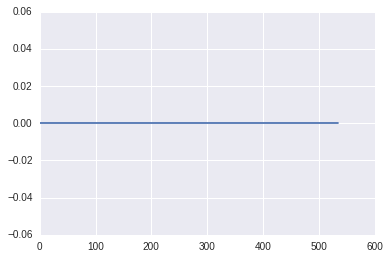

In [23]:
# plt.plot(a)
# plt.plot(b)
# plt.plot(c)
plt.plot(d)

In [26]:
sp.stats.pearsonr(b, c)

(0.12681612397610101, 0.0032711902824953611)

In [ ]:
applywarp.inputs.in_file = '/home/gdholla1/data/daphne/clean/S04/tse.nii.gz'
applywarp.inputs.ref_file = '/home/gdholla1/data/daphne/clean/S04/t1.nii.gz'
applywarp.inputs.premat = '/home/public/LC_Leiden/MRI_DATA/TSE_slab/registered_2_whole_brain/pp04_S2.nii_2_wb'
applywarp.inputs.field_file = '/home/public/LC_Leiden/MRI_DATA/TSE_slab/registered_2_whole_brain/pp04_S2_warpcoef.nii.gz'

r = applywarp.run()

In [17]:
r.outputs


out_file = /home/gdholla1/notebooks/2016_daphne/tse_warp.nii.gz

In [7]:
applywarp.inputs


abswarp = <undefined>
args = <undefined>
datatype = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
field_file = /home/public/LC_Leiden/MRI_DATA/TSE_slab/registered_2_whole_brain/pp00_S2_warpcoef.nii.gz
ignore_exception = False
in_file = /home/gdholla1/data/daphne/clean/S00/tse.nii.gz
interp = <undefined>
mask_file = <undefined>
out_file = <undefined>
output_type = NIFTI_GZ
postmat = <undefined>
premat = <undefined>
ref_file = /home/gdholla1/data/daphne/clean/S00/t1.nii.gz
relwarp = <undefined>
superlevel = <undefined>
supersample = <undefined>
terminal_output = stream

In [19]:
inverse_warp = fsl.InvWarp()

inverse_warp.inputs.warp = ''


absolute = <undefined>
args = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
ignore_exception = False
inverse_warp = <undefined>
jacobian_max = <undefined>
jacobian_min = <undefined>
niter = <undefined>
noconstraint = <undefined>
output_type = NIFTI_GZ
reference = <undefined>
regularise = <undefined>
relative = <undefined>
terminal_output = stream
warp = <undefined>

In [10]:
!cat /home/public/LC_Leiden/MRI_DATA/TSE_slab/registered_2_whole_brain/pp00_S1.nii_2_wb

1.004631749  0.0288713576  -0.06453615056  23.46124817  
-0.02924773894  0.9876365286  -0.003161054393  19.82859585  
0.06005577622  0.01729769468  0.9917865224  20.21623128  
0  0  0  1  


In [ ]:
applywarp.inputs.in_file = '/home/gdholla1/data/daphne/clean/S04/tse.nii.gz'
applywarp.inputs.ref_file = '/home/gdholla1/data/daphne/clean/S04/t1.nii.gz'
applywarp.inputs.premat = '/home/public/LC_Leiden/MRI_DATA/TSE_slab/registered_2_whole_brain/pp04_S2.nii_2_wb'
applywarp.inputs.field_file = '/home/public/LC_Leiden/MRI_DATA/TSE_slab/registered_2_whole_brain/pp04_S2_warpcoef.nii.gz'

r = applywarp.run()